<a href="../01_LTI/_index.ipynb">&larr; LTI-Index </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>

### Zeitdiskrete Systeme im Zeitbereich

In diesem Notebook wird gezeigt, wie sich einfache zeitdiskrete Filter im Zeitbereich verhalten und wie man ihre Reaktion auf Zeitsignale darstellen kann.

In [6]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp
dsp.versions() # print versions 
    
%matplotlib inline
import matplotlib.pyplot as plt 
size = {"figsize":(10,4)} # Plotgröße in Inch

import numpy as np
import scipy.signal as sig

Python version: 3.8.17
Numpy: 1.24.4
Scipy: 1.10.1
Matplotlib: 3.7.2 module://matplotlib_inline.backend_inline


## Zwei LTI-Systeme

Das folgende Bild zeigt den Signalflussgraphen eines Moving Average (MA) Filters (gleitender Mittelwert) mit der Ordnung $N=4$ und der Länge $L=5$. Die Länge ist dabei die Anzahl der Taps und entspricht der Länge der Impulsantwort.

![LTI-MA.png](../_img/LTI-MA.png)

Das folgende Bild zeigt ein Filter, das aus zwei kaskadierten MA-Filtern jeweils mit der Ordnung 2 besteht. Die Gesamtordnung des Filters ist $N=4$, die Länge ist $L=5$.

![LTI-kask_MA.png](../_img/LTI-kask_MA.png)

Sind die Impulsantworten beider Filter identisch? Wir werden das im Folgenden ausprobieren.

### Definition des Filters über seine Impulsantwort
In der nächsten Codezelle definieren wir das Filter über seine Impulsantwort (das geht natürlich nur bei FIR-Filtern). Die Impulsantwort des kaskadierten Filters erhalten wir, indem wir die Impulsantwort des ersten Teilfilters mit der des zweiten Teilfilters falten. Versuchen Sie beide Varianten:

In [7]:
# h = np.ones(10) # MA-filter, N = 4, L = 5
h = np.convolve([1,1,1],[1,1,1]) # Cascade two MA-filters, each with N = 2

## Impulsantwort des Filters
Die Impulsantwort können wir direkt plotten:

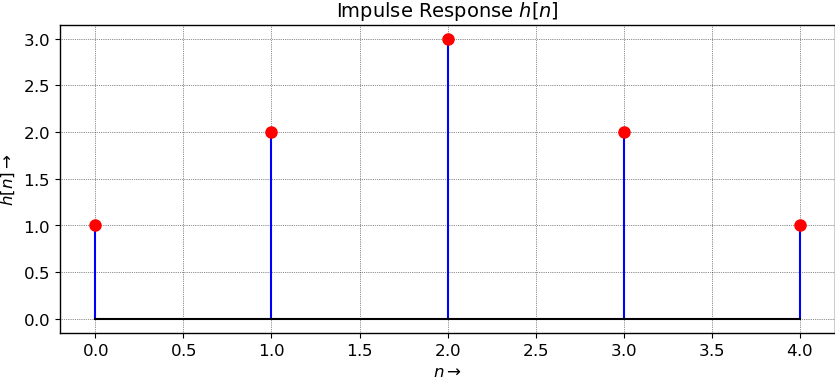

In [8]:
fig, ax = plt.subplots(**size)
ax.stem(range(len(h)), h,  linefmt='b-', markerfmt='ro', basefmt='k') # plot h[n] with blue stems, red markers, black baseline
ax.set_xlabel(r'$n \rightarrow$'); plt.ylabel(r'$h[n] \rightarrow$');
ax.set_title(r'Impulse Response $h[n]$');

## Zeitdiskrete und "analoge Signale"
Jetzt definieren wir ein einfaches sinusförmiges Testsignal $x[n]$ für unsere Filter, abgeleitet von einem "analogen" Signal $x(t)$. Der Gleichanteil soll das Nutzsignal sein, der Wechselanteil eine Brummstörung (50 Hz) repräsentieren.

  n :    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |
x[n]: 2.00 | 1.50 | 1.00 | 1.50 | 2.00 | 1.50 | 1.00 | 1.50 |

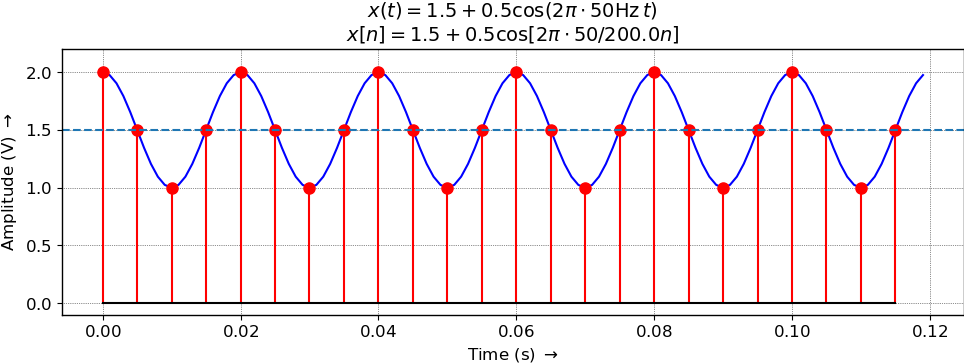

In [9]:
Ts = 1/200.0     # sampling period
fsig = 50.0      # signal frequenc
A = 0.5          # signal amplitude
phi0  = 0        # signal initial phase
tstep = 1e-3     # time step for "analog" signal
Tmax = 6.0/fsig  # timespan for 6 signal periods 
N_Ts = Tmax / Ts # number of samples in Tmax
# -- Calculate time-vectors and input signals ---
t = np.arange(0,Tmax,tstep)  # time t
n = np.arange(0,round(N_Ts)) # sample n (start,stop,step)
xt = 1.5 + A*np.cos(2.0*np.pi*fsig*t + phi0) # x(t).
xn = 1.5 + A*np.cos(2.0*np.pi*fsig*n*Ts + phi0) # x[n]

fig, ax = plt.subplots(**size) 
ax.set_xlabel(r'Time (s) $\rightarrow$')
ax.set_ylabel(r'Amplitude (V) $\rightarrow$')
ax.set_title('$x(t) = 1.5 + 0.5 \cos(2 \pi \cdot 50 \mathrm{Hz}\, t)$\n\
$x[n] = 1.5 + 0.5 \cos[2 \pi \cdot 50 / %.1f n]$'%(1./Ts))
#
ax.plot(t, xt, 'b-') # x(t) with blue line
ax.stem(n*Ts, xn, linefmt='r-', markerfmt='ro', basefmt='k') # x[n], red markers + stems, black baseline
ax.set_ylim(-0.1, 2.2)   # set y-limits to ymin, ymax
# horizontal line (relative x-coordinates):
ax.axhline(1.5, xmin=0, xmax=1, linestyle='--') 
fig.set_tight_layout(True)
# generate table
print('  n :', end="")
for i in range(8): print('{:5d} |'.format(i), end="")
print('\nx[n]:', end="")
for i in range(8): print('{0:5.2f} |'.format(xn[i]), end="")

## Gefiltertes Signal im Zeitbereich
Um das gefilterte Ausgangssignal $y[n]$ zu berechnen, falten wir das Testsignal $x[n]$ mit der Impulsantwort des Filters $h[n]$:


y[n]: 0.20 0.55 1.00 1.20 1.30 1.35 1.40 1.35

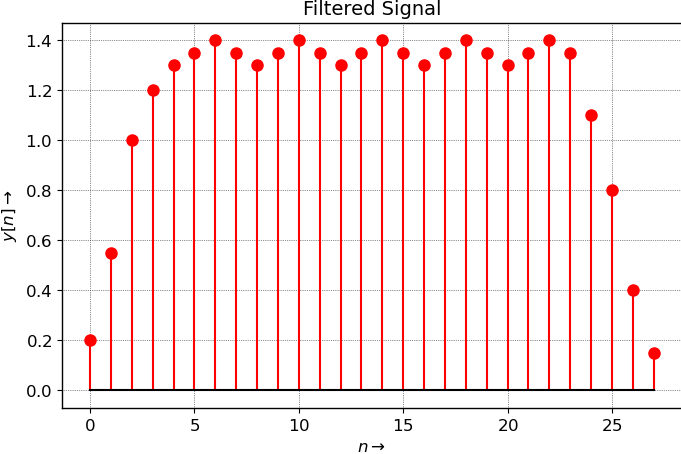

In [10]:
fig,ax = plt.subplots(figsize=(8,5))
yn = np.convolve(xn,h) / 10 # convolve signal and response
print('\ny[n]:', end="")
for i in range(8): print('{0:5.2f}'.format(yn[i]), end="")
ax.stem(range(len(yn)), yn, linefmt='r-', markerfmt='ro', basefmt='k') # y[n]
ax.set_xlabel(r'$n \rightarrow$'); plt.ylabel(r'$y[n] \rightarrow$')
ax.set_title('Filtered Signal');

**Aufgaben:**
- Warum ist die Länge eines FIR-Filters immer genau eins größer als die Ordnung? Betrachten Sie dazu die obigen Signalflussgraphen.
- Experimentieren Sie mit verschiedenen Längen für das MA-Filter, interpretieren Sie die Ergebnisse. Was passiert beim MA-Filter der Ordnung $N=3$?
- Warum ist die Höhe des Gleichanteils am Ausgang anders als am Eingang? Korrigieren Sie den Skalierungsfehler im Code.
- Schätzen Sie die Unterdrückung des Gleichsignals aus den Simulationsplots ab.

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2021*.